# With Dec=5e-10, Dcross=1e-14, Xi=-1.4; t_0+=0.28, Nyman008, run 1C cycling for 500 times and see what happen

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp,tanh,sqrt;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
import traceback
import imageio.v2 as imageio
font = {'family' : 'Times New Roman',
        #'weight' : 'bold',
        'size'   : fs}
mpl.rc('font', **font)

In [2]:
V_max = 4.2;        V_min = 2.5;
total_cycle = 500; save_at_cycles= 50
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 1 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * total_cycle ) 
Experiment_s   = pybamm.Experiment( [ (
    f"Discharge at 1 C for 240 s", )    ] * 1 )   

In [3]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R5/'; 
Target  = 'a0_based/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [4]:
Model_d = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "EC wo refill"     } )
Model_dre = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "EC w refill"     } )
Model_s = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "none"     } )


Confirm: using solvent-diffusion limited
using EC wo refill for Li+
Confirm: using solvent-diffusion limited
using EC w refill for Li+
Confirm: using solvent-diffusion limited


In [10]:
Models = [Model_s,Model_d,Model_dre]
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Nyman2008_rio";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
Para_0['EC transference number'] =     -1.4
Para_0['Cation transference number'] =     0.28
Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = 1e-14
Para_0['Typical EC Lithium ion cross diffusivity [m2.s-1]'] =  1e-14
Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  5e-10
#print(Model_d.options["solvent diffusion"])
for model in Models:
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    c_EC = model.variables["EC concentration [mol.m-3]"]
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["Electrolyte conductivity [S.m-1]"] =(
        Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
    model.variables["Electrolyte diffusivity [m2.s-1]"] =(
        Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))

EC wo refill


Xi =  list(np.linspace(-1.8, -1.0, 10))
print(type(Xi))

In [13]:
Sim = [];Sol=[]; 
for model in Models:
    sim = pybamm.Simulation(
        model, experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pybamm.CasadiSolver(),)  
    try:
        sol = sim.solve(save_at_cycles=save_at_cycles,);
    except:
        print('Fail for model option: ',model.options["solvent diffusion"])
    else:
        Sol.append(sol)   
        print('Succeed for model option: ',model.options["solvent diffusion"])

Succeed for model option:  none
Succeed for model option:  EC wo refill
Succeed for model option:  EC w refill


In [15]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2_Crack_simp import (
    GetScan,
    recursive_scan,
    GetSol_dict,
    Para_init,
    Run_model_wwo_dry_out ,
    Cal_new_con_Update,
    Run_Model_Base_On_Last_Solution,
    Run_Model_Base_On_Last_Solution_RPT,
    write_excel_xlsx,
    Get_initial_cap,
    Get_initial_cap2
)

In [24]:
# post-processing
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",

    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",

    "CDend EC concentration [mol.m-3]",
    "CDend Electrolyte concentration [mol.m-3]",

    "CDend EC flux [mol.m-2.s-1]",
    "CDend EC flux by diffusion [mol.m-2.s-1]",
    "CDend EC flux by migration [mol.m-2.s-1]",
    "CDend EC flux by Li+ [mol.m-2.s-1]",
    "CDend Li+ flux [mol.m-2.s-1]",
    "CDend Li+ flux by diffusion [mol.m-2.s-1]",
    "CDend Li+ flux by migration [mol.m-2.s-1]",
    "CDend Li+ flux by solvent [mol.m-2.s-1]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDend Loss of capacity to SEI [A.h]",]

keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];



In [20]:
total_cycle = 500; save_at_cycles= 50;
step_CD = 0;step_CC=1;step_CV = 2;
cycle_no = np.arange(-1,total_cycle,save_at_cycles);
cycle_no[0] = 0;
my_dict_all = []
print(cycle_no)
for sol in Sol:
    my_dict = {}; 
    for keys in keys_all_RPT:
        for key in keys:
            my_dict[key]=[];
    for cycle_i in cycle_no:
        my_dict_old = my_dict; del my_dict
        my_dict = GetSol_dict (my_dict_old,keys_all_RPT, sol, 
            cycle_i, step_CD , step_CC , -1, step_CV   )
    my_dict_all.append(my_dict)


[  0  49  99 149 199 249 299 349 399 449 499]


print(Sol_ddiff["Electrolyte conductivity [S.m-1]"].entries[:,51] )
print(Sol_ddiff["Electrolyte diffusivity [m2.s-1]"].entries[:,-1])

Text(0.5, 1.0, 'Capacity loss to SEI')

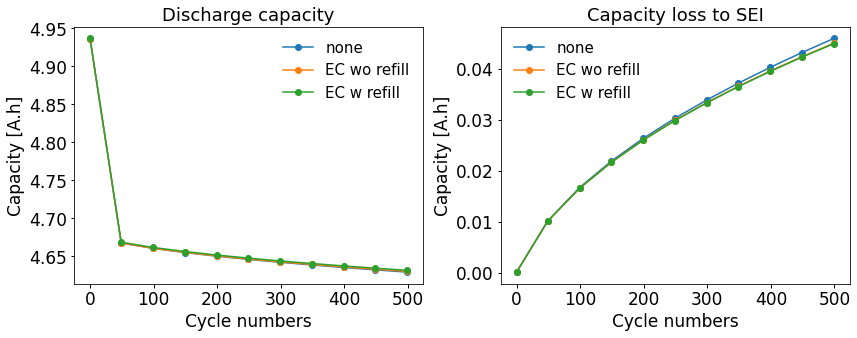

In [23]:
fs=17;Num_subplot = 2;
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
for model,my_dict in zip(Models,my_dict_all):
    axs[0].plot(
        cycle_no, 
        my_dict["Discharge capacity [A.h]"],'-o', 
        label=model.options["solvent diffusion"] )
    axs[1].plot(
        cycle_no, 
        my_dict["CDend Loss of capacity to SEI [A.h]"] ,'-o', 
        label=model.options["solvent diffusion"] )
for i in range(0,Num_subplot):
    axs[i].set_xlabel("Cycle numbers",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)
    axs[i].set_title("Discharge capacity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("Capacity loss to SEI",   fontdict={'family':'DejaVu Sans','size':fs+1})

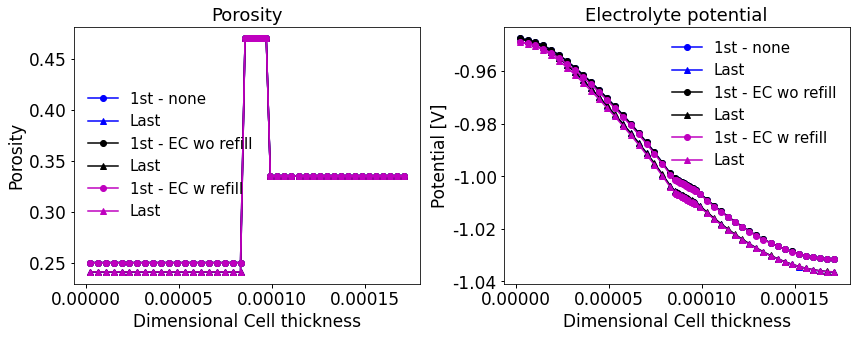

In [30]:
Num_subplot = 2;str_color = ['b', 'k', 'm']
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
for model,my_dict,co in zip(Models,my_dict_all,str_color):
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Porosity"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"])
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Porosity"][-1],'-^',color=co,label="Last")
    axs[1].plot(my_dict["x [m]"], my_dict["CDend Electrolyte potential [V]"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"] )
    axs[1].plot(my_dict["x [m]"], my_dict["CDend Electrolyte potential [V]"][-1],'-^',color=co,label="Last" )
axs[0].set_title("Porosity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("Electrolyte potential",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Porosity",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1].set_ylabel("Potential [V]",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    axs[i].set_xlabel("Dimensional Cell thickness",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    

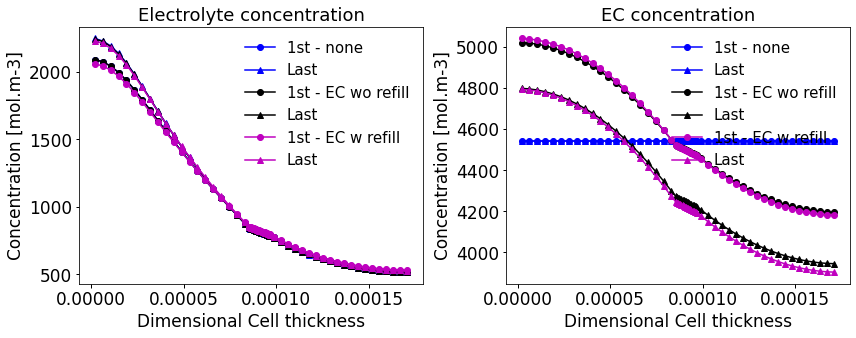

In [29]:
Num_subplot = 2;str_color = ['b', 'k', 'm']
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
for model,my_dict,co in zip(Models,my_dict_all,str_color):
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Electrolyte concentration [mol.m-3]"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"])
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Electrolyte concentration [mol.m-3]"][-1],'-^',color=co,label="Last")
    axs[1].plot(my_dict["x [m]"], my_dict["CDend EC concentration [mol.m-3]"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"] )
    axs[1].plot(my_dict["x [m]"], my_dict["CDend EC concentration [mol.m-3]"][-1],'-^',color=co,label="Last" )
axs[0].set_title("Electrolyte concentration",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("EC concentration",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    axs[i].set_xlabel("Dimensional Cell thickness",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    